In [91]:
import pandas as pd

matches = pd.read_csv("atp_matches_2018.csv")
atp_players = pd.read_csv("atp_players.csv")
atp_rankings_10s = pd.read_csv("atp_rankings_10s.csv")

year = 2018
matches_file_name = "atp_matches_2018_cleaned.csv"
players_file_name = "atp_players_2018_cleaned.csv"

output_gz_path = "graph2018.gz"
output_gml_path = "graph2018.gml"

In [92]:
import networkx as nx

import collections
from collections import Counter

import matplotlib
from matplotlib import pyplot as plt

import math

from networkx.algorithms import community as comm
import itertools

from operator import itemgetter

import string

import numpy as np

from sklearn import cluster

import copy

# Ciscenje podataka

## Brisanje grupnih turnira

In [93]:
matches = matches[['tourney_id','tourney_name','winner_id','loser_id','surface']]

indexes=[]
for index,tourney_id,tourney_name,winner_id,loser_id,surface in matches.itertuples():
    if ("Davis Cup" in tourney_name):
        indexes.append(index)        
        
matches = matches.drop(indexes)  

In [94]:
from datetime import date

def get_num_of_days_between(start_date_int,end_date_int):
    start_date = date(int(start_date_int/10000), int(int(start_date_int%10000)/100), int(start_date_int%100))
    end_date = date(int(end_date_int/10000), int(int(end_date_int%10000)/100), int(end_date_int%100))
    difference = end_date - start_date
    return difference.days

def get_player_ranking(id,year):
    next_year=(year+1)*10000
    year*=10000
    ranks = atp_rankings_10s[(atp_rankings_10s['player']==id) & (atp_rankings_10s['ranking_date']>=year) & (atp_rankings_10s['ranking_date']<next_year)]
    ranks=ranks.reset_index()
    days_sum=0
    calc_rank=0
    for i in range(len(ranks)-1):
        rank = ranks.loc[i,'rank']
        start_date = ranks.loc[i,'ranking_date']
        end_date = ranks.loc[i+1,'ranking_date']
        days = get_num_of_days_between(start_date,end_date)
        calc_rank += rank*days
        days_sum +=days   
    return calc_rank/days_sum if days_sum != 0 else float('NaN')

In [95]:
winners = set(matches['winner_id'].unique())
losers = set(matches['loser_id'].unique())

players_ids = winners.union(losers)
print(f"Postoji { len(players_ids) } različitih igrača") 

players_with_attr_list = [(player_id,first_name+' '+last_name,country_code,get_player_ranking(player_id,year)) for _,player_id,first_name,last_name,hand,birth_date,country_code in atp_players.itertuples() if player_id in players_ids]
players_with_attr = pd.DataFrame(players_with_attr_list,columns =['player_id', 'player_name','country_code','rank'])

players = (players_with_attr.set_index('player_id')).to_dict('index')
#players = players.set_index('player_id')
#players = pd.DataFrame.from_dict(players_with_attr.set_index('player_id').to_dict('index'),orient='index')

Postoji 291 različitih igrača


## Cuvanje sekundarnog skupa podataka

In [96]:
matches.to_csv(matches_file_name, index = False, header=True)
#pd.DataFrame.from_dict(players,orient='index').to_csv(players_file_name, index = True, header=True)

# Modelovanje grafova

In [97]:
G = nx.Graph()
G.add_nodes_from(players_ids)

nx.set_node_attributes(G, players)

### Dodavanje tezinskih grana 

In [98]:
edge_data = matches[['winner_id','loser_id']]
for _,winner_id,loser_id in edge_data.itertuples():
    if (winner_id, loser_id) in G.edges:
        G.edges[winner_id, loser_id]['weight'] += 1
    else:
        G.add_edge(winner_id, loser_id, weight=1)
        
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 291
Number of edges: 2271
Average degree:  15.6082


## Pomocni graf turnira 

In [99]:
tourney_graph = nx.Graph()

tourney_graph.add_nodes_from(players_ids, node_type='player')
nx.set_node_attributes(tourney_graph, players)

tourney_names = matches['tourney_name'].unique()
tourney_graph.add_nodes_from(tourney_names, node_type='tourney')  

## Dodavanje tezinskih grana 

In [100]:
edge_data = matches[['winner_id','loser_id','tourney_name']]
for _,winner_id,loser_id,tourney_name in edge_data.itertuples():
    if (winner_id, tourney_name) in tourney_graph.edges:
        tourney_graph.edges[winner_id, tourney_name]['weight'] += 1
    else:
        tourney_graph.add_edge(winner_id, tourney_name, weight=1)
    if (loser_id, tourney_name) in tourney_graph.edges:
        tourney_graph.edges[loser_id, tourney_name]['weight'] += 1
    else:
        tourney_graph.add_edge(loser_id, tourney_name, weight=1)  
        
print(nx.info(tourney_graph))

Name: 
Type: Graph
Number of nodes: 359
Number of edges: 2704
Average degree:  15.0641


## Surface atribut

In [101]:
tourney_nodes = [node for node, node_type in tourney_graph.nodes(data='node_type') if node_type=='tourney']

for tourney in tourney_nodes:
    tourney_graph.nodes[tourney]['surface'] = matches[matches['tourney_name']==tourney].iloc[0].surface

# Pomocne metode (uz modelovan graf)

In [102]:
def get_player_by_name(player_name):
    nodes = [node for node,name in G.nodes(data='player_name') if name==player_name]
    player = 0
    if len(nodes)>0:
        player = nodes[0]
    return player

def get_players_matches(id):
    mask = (matches['winner_id']==id) | (matches['loser_id']==id)
    return matches[mask]

In [103]:
def get_nodes_by_attribute(G,attribute, value):
    return [n for n,v in G.nodes(data=True) if v[attribute] == value]

In [104]:
def get_players_degrees(G,players):
    return [(node,name,G.degree(node)) for (node,name) in tourney_graph.nodes(data='player_name') if node in players]

In [105]:
def get_player_attribute(G,player,attribute):
    return [v[attribute] for n,v in G.nodes(data=True) if  n== player]

In [106]:
def get_player_info(id):
    return (id,G.nodes[id]['player_name'],G.nodes[id]['rank'],G.nodes[id]['country_code'])
    #return tuple([(node,attr['player_name'],attr['rank'],attr['country_code']) for (node,attr) in G.nodes(data=True) if node==id])

def get_players_info(players):
    infos = []
    for player in players:
        infos.append(get_player_info(player))
    return infos  

In [107]:
def get_players_opponents_info(id):
    opponents = nx.node_connected_component(G, id)
    return get_players_info(opponents)

In [108]:
def plot_deg_frequency(G, weighted=False, xscale = "log", yscale = "log"):

    if weighted:
        degrees = G.degree(weight="weight")
    else:
        degrees = G.degree()
    _, deg_list = zip(*degrees)    #unzip
    deg_counts = Counter(deg_list) #prebrojava, 1, 2, ..        
    print(deg_counts)
    degree, frequency = zip(*deg_counts.items())                                                      

    plt.figure(1)   

    # prep axes   
    if weighted:
        plt.xlabel('weighted degree')  
    else:
        plt.xlabel('degree')                                                                                                             
    plt.xscale(xscale)                                                                                                                
    plt.xlim(1, max(degree))  

    plt.ylabel('frequency')                                                                                                          
    plt.yscale(yscale)                                                                                                                
    plt.ylim(1, max(frequency))                                                                                                             
                                                                                                                                                                                                    
    plt.scatter(degree, frequency, marker='.')                                                                                                    
    plt.show()

# Istrazivacka pitanja

# 1. Koliki je prosečan broj tenisera (saigrača) po svakom teniseru?

In [109]:
def get_average_degree(G):
    num_of_nodes = G.number_of_nodes()
    degree = sum(d for n, d in G.degree()) / float(num_of_nodes)
    return degree

def get_average_weighted_degree(G):
    num_of_nodes = G.number_of_nodes()
    degree = sum(d for n, d in G.degree(weight='weight')) / float(num_of_nodes)
    return degree  

In [110]:
print(f"Prosecan broj saigraca svakog tenisera: {get_average_degree(G)}")   

Prosecan broj saigraca svakog tenisera: 15.608247422680412


In [111]:
print(f"Prosecan broj meceva svakog tenisera: {get_average_weighted_degree(G)}")

Prosecan broj meceva svakog tenisera: 18.233676975945016


# 2. Koji teniseri su se susretali sa najvećim brojem drugih tenisera? 

In [112]:
degrees = [G.degree(node) for node in G.nodes()]
max_degree = max(degrees)

players_degrees = [(node,name,G.degree(node)) for (node,name) in G.nodes(data='player_name')]

high_degree_players = (sorted(players_degrees, key=lambda element: (element[2]),reverse=True))[:10]

print(f"Max stepen: {max_degree}")
print(f"Igraci koji su igrali sa najvise drugih igraca: {high_degree_players}")

Max stepen: 59
Igraci koji su igrali sa najvise drugih igraca: [(104926, 'Fabio Fognini', 59), (126774, 'Stefanos Tsitsipas', 53), (100644, 'Alexander Zverev', 52), (106233, 'Dominic Thiem', 52), (104468, 'Gilles Simon', 50), (104755, 'Richard Gasquet', 49), (111575, 'Karen Khachanov', 49), (133430, 'Denis Shapovalov', 48), (104269, 'Fernando Verdasco', 48), (106421, 'Daniil Medvedev', 48)]


In [113]:
[(p[1],(p[2])) for p in high_degree_players]

[('Fabio Fognini', 59),
 ('Stefanos Tsitsipas', 53),
 ('Alexander Zverev', 52),
 ('Dominic Thiem', 52),
 ('Gilles Simon', 50),
 ('Richard Gasquet', 49),
 ('Karen Khachanov', 49),
 ('Denis Shapovalov', 48),
 ('Fernando Verdasco', 48),
 ('Daniil Medvedev', 48)]

# 3. Koji teniseri su učestvovali na najvećem broju (različitih) turnira?

In [114]:
player_tourney_degrees = [(node,name,tourney_graph.degree(node)) for (node,name) in tourney_graph.nodes(data='player_name') if node in players]

high_tourney_degree_players = (sorted(player_tourney_degrees, key=lambda element: (element[2]),reverse=True))[:10]

print(f"Igraci koji su ucestvovali na najvecem broju turnira: {high_tourney_degree_players}")

Igraci koji su ucestvovali na najvecem broju turnira: [(106000, 'Damir Dzumhur', 31), (104999, 'Mischa Zverev', 30), (105173, 'Adrian Mannarino', 29), (126774, 'Stefanos Tsitsipas', 29), (104898, 'Robin Haase', 28), (105932, 'Nikoloz Basilashvili', 28), (105077, 'Albert Ramos', 28), (104269, 'Fernando Verdasco', 28), (105332, 'Benoit Paire', 28), (133430, 'Denis Shapovalov', 27)]


In [115]:
[(p[1],(p[2])) for p in high_tourney_degree_players]

[('Damir Dzumhur', 31),
 ('Mischa Zverev', 30),
 ('Adrian Mannarino', 29),
 ('Stefanos Tsitsipas', 29),
 ('Robin Haase', 28),
 ('Nikoloz Basilashvili', 28),
 ('Albert Ramos', 28),
 ('Fernando Verdasco', 28),
 ('Benoit Paire', 28),
 ('Denis Shapovalov', 27)]

# 4. Koji teniseri su dobri kandidati za predstavnike profesionalnih tenisera? 
## Da li i šta se menja ukoliko se umesto jednog bira skup od nekoliko predstavnika?
### Dobar predstavnik ili predstavnici bi trebalo da budu u kontaktu sa što većim skupom tenisera.

In [116]:
#Mozda po lokalnoj centralnosti? - Čvor je lokalno centralan ako ima veći broj veza sa svojim okruženjem
degree_centralities = [(node, centrality) for node, centrality in nx.degree_centrality(G).items()]

max_degree_centralities = sorted(degree_centralities,key=lambda item: item[1], reverse=True)[:10]

high_degree_centrality_players = [(get_player_info(player[0]), player[1]) for player in max_degree_centralities]

print(f"Dobri kandidati za predstavnika profesionalnih tenisera su")
high_degree_centrality_players

Dobri kandidati za predstavnika profesionalnih tenisera su


[((104926, 'Fabio Fognini', 16.98076923076923, 'ITA'), 0.20344827586206896),
 ((126774, 'Stefanos Tsitsipas', 41.19230769230769, 'GRE'),
  0.18275862068965518),
 ((100644, 'Alexander Zverev', 4.038461538461538, 'GER'), 0.1793103448275862),
 ((106233, 'Dominic Thiem', 7.230769230769231, 'AUT'), 0.1793103448275862),
 ((104468, 'Gilles Simon', 51.23076923076923, 'FRA'), 0.1724137931034483),
 ((104755, 'Richard Gasquet', 29.596153846153847, 'FRA'), 0.16896551724137931),
 ((111575, 'Karen Khachanov', 32.42307692307692, 'RUS'), 0.16896551724137931),
 ((133430, 'Denis Shapovalov', 34.38461538461539, 'CAN'), 0.16551724137931034),
 ((104269, 'Fernando Verdasco', 33.32692307692308, 'ESP'),
  0.16551724137931034),
 ((106421, 'Daniil Medvedev', 44.73076923076923, 'RUS'), 0.16551724137931034)]

In [117]:
#Eigenvector centrality - Varijanta centralnosti po stepenu koja uzima u obzir i susedstvo posmatranog čvora
#onaj sa najvecom plus njegovi susedi??
eigenvector_centralities = [(node, centrality) for node, centrality in nx.eigenvector_centrality(G).items()]

#prvih 10
max_eigenvector_centralities = sorted(eigenvector_centralities,key=lambda item: item[1], reverse=True)[:10]

high_eigenvector_centrality_players = [(get_player_info(player[0]), player[1]) for player in max_eigenvector_centralities]

print(f"Dobri kandidati za predstavnika profesionalnih tenisera su")
high_eigenvector_centrality_players

Dobri kandidati za predstavnika profesionalnih tenisera su


[((100644, 'Alexander Zverev', 4.038461538461538, 'GER'), 0.14928940006591934),
 ((106233, 'Dominic Thiem', 7.230769230769231, 'AUT'), 0.14610597765557917),
 ((104926, 'Fabio Fognini', 16.98076923076923, 'ITA'), 0.14141254392714),
 ((105223, 'Juan Martin Del Potro', 5.673076923076923, 'ARG'),
  0.13975339439871368),
 ((126774, 'Stefanos Tsitsipas', 41.19230769230769, 'GRE'),
  0.13833760253612984),
 ((104731, 'Kevin Anderson', 7.788461538461538, 'RSA'), 0.1368199790367423),
 ((106421, 'Daniil Medvedev', 44.73076923076923, 'RUS'), 0.13590654991142284),
 ((103819, 'Roger Federer', 2.0576923076923075, 'SUI'), 0.1355171840663064),
 ((104755, 'Richard Gasquet', 29.596153846153847, 'FRA'), 0.13494101632833153),
 ((105453, 'Kei Nishikori', 20.615384615384617, 'JPN'), 0.13202915869754062)]

# 5. Kako su rangirani na ATP listi teniseri koji su se susretali sa najvećim brojem drugih tenisera?

In [118]:
high_degree_players_ids = list(list(zip(*high_degree_players))[0])

high_degree_players_ranks = [(node,attr['player_name'],G.degree(node),attr['rank']) for (node,attr) in G.nodes(data=True) if node in high_degree_players_ids]
high_degree_players_ranks = sorted(high_degree_players_ranks,key=lambda item: item[3])
high_degree_players_ranks

[(100644, 'Alexander Zverev', 52, 4.038461538461538),
 (106233, 'Dominic Thiem', 52, 7.230769230769231),
 (104926, 'Fabio Fognini', 59, 16.98076923076923),
 (104755, 'Richard Gasquet', 49, 29.596153846153847),
 (111575, 'Karen Khachanov', 49, 32.42307692307692),
 (104269, 'Fernando Verdasco', 48, 33.32692307692308),
 (133430, 'Denis Shapovalov', 48, 34.38461538461539),
 (126774, 'Stefanos Tsitsipas', 53, 41.19230769230769),
 (106421, 'Daniil Medvedev', 48, 44.73076923076923),
 (104468, 'Gilles Simon', 50, 51.23076923076923)]

# 6.  Iz kojih zemalja dolazi najveći broj aktivnih igrača u proteklom periodu?

In [119]:
def plot_players_per_country_frequency(G, xscale = "linear", yscale = "linear"):

    countries = [country for node,country in G.nodes(data='country_code')]
    countries_counts = Counter(countries) #prebrojava, 1, 2, ..        
    print(countries_counts)
    lists = sorted(countries_counts.items(),key=lambda item: item[1])
    x, y = zip(*lists)                                                      

    fig = plt.figure(1) 
    fig.set_size_inches(20,20)
    plt.barh(x,y)
    #plt.ylabel('Country')
    plt.xlabel('Број играча')
    plt.show()

Counter({'USA': 34, 'FRA': 25, 'ESP': 23, 'GER': 17, 'ITA': 17, 'ARG': 15, 'AUS': 14, 'AUT': 8, 'RUS': 7, 'CAN': 7, 'GBR': 6, 'SRB': 6, 'CZE': 6, 'SVK': 6, 'CRO': 6, 'JPN': 6, 'CHN': 5, 'POR': 5, 'IND': 5, 'BRA': 5, 'SUI': 4, 'BEL': 3, 'BUL': 3, 'HUN': 3, 'NED': 3, 'DOM': 2, 'CHI': 2, 'UKR': 2, 'RSA': 2, 'SWE': 2, 'BIH': 2, 'SLO': 2, 'KAZ': 2, 'TUR': 2, 'COL': 2, 'BLR': 2, 'KOR': 2, 'TPE': 2, 'ALG': 1, 'POL': 1, 'ISR': 1, 'LTU': 1, 'CYP': 1, 'ZIM': 1, 'EGY': 1, 'ESA': 1, 'ROU': 1, 'URU': 1, 'UZB': 1, 'MON': 1, 'MAR': 1, 'GEO': 1, 'ECU': 1, 'BAR': 1, 'NZL': 1, 'NOR': 1, 'EST': 1, 'LUX': 1, 'LAT': 1, 'GRE': 1, 'QAT': 1, 'TUN': 1, 'MEX': 1, 'MDA': 1})


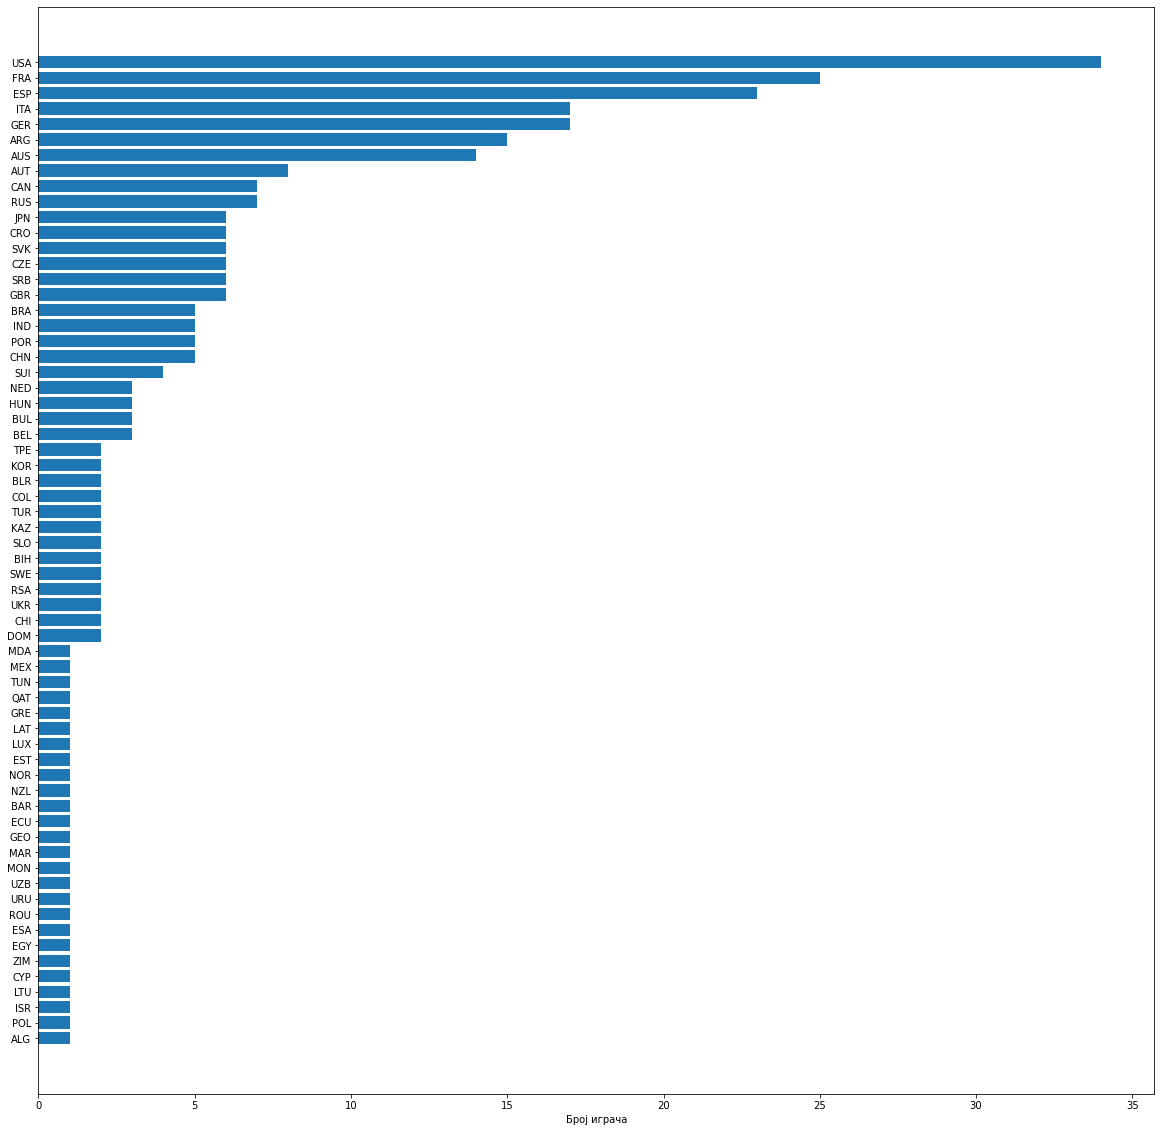

In [120]:
plot_players_per_country_frequency(G)

# 7. Iz kojih zemalja dolaze najuspešniji igrači u smislu osvojenih poena na ATP listi?

In [121]:
def get_first_atp_players(num):
    player_ranks = [(node,attr['player_name'],attr['rank'],attr['country_code']) for (node,attr) in G.nodes(data=True)]

    player_ranks = (list(filter(lambda x: math.isnan(x[2])==False, player_ranks)))
    player_ranks = (sorted(player_ranks, key=lambda element: (element[2]),reverse=False))[:num]
    return player_ranks
    

In [122]:
def plot_best_players_per_country_frequency(countries, xscale = "linear", yscale = "linear"):
    countries_counts = Counter(countries) #prebrojava, 1, 2, ..        
    print(countries_counts)
    lists = sorted(countries_counts.items(),key=lambda item: item[1])
    x, y = zip(*lists)                                                    

    fig = plt.figure(1) 
    fig.set_size_inches(20,20)
    plt.barh(x,y)
    plt.ylabel('Country')
    plt.xlabel('num of players')
    plt.show()

Counter({'USA': 10, 'FRA': 10, 'ESP': 9, 'GER': 6, 'ITA': 6, 'ARG': 5, 'AUS': 5, 'RUS': 5, 'SRB': 4, 'CRO': 3, 'JPN': 3, 'CAN': 3, 'SUI': 2, 'GBR': 2, 'BIH': 2, 'CZE': 2, 'SVK': 2, 'AUT': 1, 'BUL': 1, 'RSA': 1, 'BEL': 1, 'KOR': 1, 'GRE': 1, 'NED': 1, 'HUN': 1, 'GEO': 1, 'POR': 1, 'URU': 1, 'CHI': 1, 'SLO': 1, 'TUN': 1, 'LUX': 1, 'KAZ': 1, 'ROU': 1, 'UZB': 1, 'MDA': 1, 'CYP': 1, 'IND': 1})


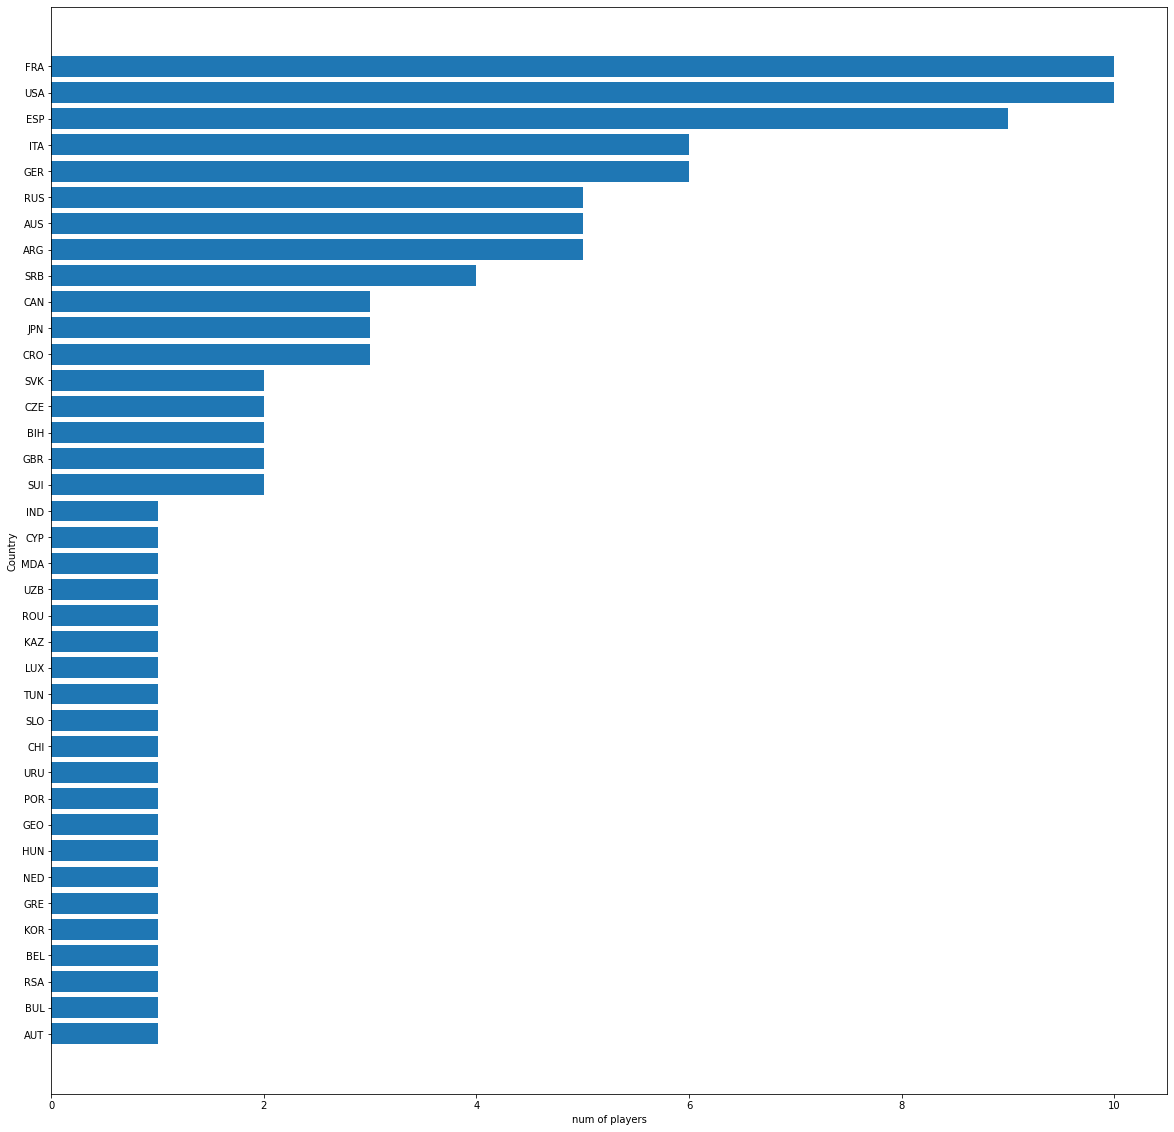

In [123]:
countries = get_first_atp_players(100)
_,_,_,countries = zip(*countries)

#za USA se dosta vidi razlika u 100 i 1000
#ali se pitanje odnosi na najuspesnije
plot_best_players_per_country_frequency(countries)

# 8. Kako su u okviru skupa podataka okarakterisani igrači iz Srbije?

In [124]:
serbian_players = [player for player,country in G.nodes(data='country_code') if country=='SRB']

serbian_players_ranks = [(get_player_info(player)[1],rank) for player,rank in G.nodes(data='rank') if player in serbian_players]
print(f"Po ranku srpski igraci su: {serbian_players_ranks}\n")

serbian_players_matches = [(get_player_info(player)[1],degree) for player,degree in G.degree(weight='weight') if player in serbian_players]
print(f"Po broju meceva srpski igraci su: {serbian_players_matches}\n")

serbian_players_opponents = [(get_player_info(player)[1],degree) for player,degree in G.degree() if player in serbian_players]
print(f"Po broju saigraca srpski igraci su: {serbian_players_opponents}\n")


#Mozda u odnos na druge zemlje?

Po ranku srpski igraci su: [('Dusan Lajovic', 68.0), ('Viktor Troicki', 113.01923076923077), ('Filip Krajinovic', 40.96153846153846), ('Novak Djokovic', 10.173076923076923), ('Miomir Kecmanovic', 179.3846153846154), ('Laslo Djere', 92.61538461538461)]

Po broju meceva srpski igraci su: [('Dusan Lajovic', 46), ('Viktor Troicki', 19), ('Filip Krajinovic', 31), ('Novak Djokovic', 65), ('Miomir Kecmanovic', 2), ('Laslo Djere', 27)]

Po broju saigraca srpski igraci su: [('Dusan Lajovic', 41), ('Viktor Troicki', 19), ('Filip Krajinovic', 25), ('Novak Djokovic', 42), ('Miomir Kecmanovic', 2), ('Laslo Djere', 25)]



# 9. Koje zajednice (komune) se mogu uočiti prilikom analize mreže? Da li postoji neko objašnjenje za detektovane komune?

In [125]:
#Clauset-Newman-Moore pohlepni algoritam
communities = comm.greedy_modularity_communities(G, weight='weight')
communities = [list(community) for community in communities]

# communities_info = {}
# i=0
# for community in communities:
#     i+=1
#     communities_info[i] = get_players_info(community)

communities_info = {}
for i in range(0,len(communities)):
    communities_info[i+1] = get_players_info(communities[i])
    
# communities_info

# 10. Sprovesti analizu klasterisanja i asortativnu analizu, pa uporediti grupisanje na osnovu zemlje iz koje igrači dolaze, na osnovu broja mečeva koje igraju i na osnovu rejtinga.

# Analiza klasterisanja

In [126]:
#Lokalni koeficijent klasterizacije
#računa se kao gustina mreže koju čine posmatrani čvor, njegovi susedi i njihove međusobne veze

player_id, clustering_coef = zip(*nx.clustering(G, weight = "weight").items())

not_zero_cc_players = [(get_player_info(player),cc,degree[1])  for player, cc, degree in zip(player_id, clustering_coef, G.degree(weight='weight')) if cc > 0]
not_zero_cc_players = (sorted(not_zero_cc_players, key=lambda element: (element[1]),reverse=True))

max_local_clustering_coef = max(clustering_coef)

average_clustering_coef = nx.average_clustering(G)

print(f"Max lokalni cc: {max_local_clustering_coef}")
print(f"Prosečan cc: {average_clustering_coef}")
print("Lokalni stepeni klasterisanja koji nisu nula:")
not_zero_cc_players

Max lokalni cc: 0.20000000000000004
Prosečan cc: 0.17372693059959773
Lokalni stepeni klasterisanja koji nisu nula:


[((104467, 'Lamine Ouahab', 528.7692307692307, 'ALG'), 0.20000000000000004, 2),
 ((104672, 'Vincent Millot', 306.86538461538464, 'FRA'),
  0.20000000000000004,
  2),
 ((200175, 'Miomir Kecmanovic', 179.3846153846154, 'SRB'),
  0.20000000000000004,
  2),
 ((126523, 'Bernabe Zapata Miralles', 280.38461538461536, 'ESP'),
  0.20000000000000004,
  2),
 ((106105, 'Guilherme Clezar', 221.73076923076923, 'BRA'),
  0.20000000000000004,
  2),
 ((106361, 'Adam Pavlasek', 200.40384615384616, 'CZE'),
  0.20000000000000004,
  2),
 ((106412, 'Lucas Gomez', 760.2307692307693, 'MEX'), 0.20000000000000004, 2),
 ((132482, 'Liam Caruana', 512.7884615384615, 'USA'), 0.192658771656154, 4),
 ((133297, 'Yosuke Watanuki', 292.40384615384613, 'JPN'),
  0.13333333333333336,
  3),
 ((136440, 'Dominik Koepfer', 222.71153846153845, 'GER'),
  0.13333333333333336,
  3),
 ((106005, 'Constant Lestienne', 210.25, 'FRA'), 0.13333333333333336, 3),
 ((106296, 'Gregoire Barrere', 256.2307692307692, 'FRA'),
  0.1333333333333

## Asortativnost 

In [127]:
# asortativnost na osnovu netežinskog stepena čvora
graph_ass = nx.degree_assortativity_coefficient(G)
print(f"Koeficijent asortativnosti na osnovu netežinskog stepena čvora: {graph_ass}")

# asortativnost na osnovu težinskog stepena čvora
graph_weighted_ass = nx.degree_assortativity_coefficient(G, weight='weight')
print(f"Koeficijent asortativnosti na osnovu težinskog stepena cvora (broja meceva): {graph_weighted_ass}")

#Umereno asortativna mreza? - vezivanje cvorova koji su slicni

# asortativnost na osnovu ranka
graph_rank_ass = nx.attribute_assortativity_coefficient(G, 'rank')
print(f"Koeficijent asortativnosti na osnovu ranka čvora: {graph_rank_ass}")

#U grupe??

Koeficijent asortativnosti na osnovu netežinskog stepena čvora: 0.07197468792309131
Koeficijent asortativnosti na osnovu težinskog stepena cvora (broja meceva): 0.10573291351025647
Koeficijent asortativnosti na osnovu ranka čvora: -0.007191025849709368


In [128]:
max_rank = max([rank for (node,rank) in G.nodes(data='rank')])

def getRankGroup(rank):
    if rank<100:
        return 'group100'
    if rank<250:
        return 'group250'
    if rank<500:
        return 'group500'
    if rank<2000:
        return 'group2000'
    return 'theLastGroup'

def addRankGroupAttributes():
    for player in players:
        G.nodes[player]['rank_group']=getRankGroup(G.nodes[player]['rank'])

In [129]:
addRankGroupAttributes()

graph_rank_group_ass = nx.attribute_assortativity_coefficient(G, 'rank_group')
print(f"Koeficijent asortativnosti na osnovu kategorije ranka čvora: {graph_rank_group_ass}")

Koeficijent asortativnosti na osnovu kategorije ranka čvora: 0.07537049559247427


In [130]:
# asortativnost na osnovu drzave
graph_rank_ass = nx.attribute_assortativity_coefficient(G, 'country_code')
print(f"Koeficijent asortativnosti na osnovu drzave: {graph_rank_ass}")

Koeficijent asortativnosti na osnovu drzave: 0.01729479120178515


# 11. U kojoj meri teniseri imaju tendenciju da se susreću sa istim teniserima? Da li na to utiče njihovo rangiranje na ATP listi?


In [131]:
def plot_num_of_opponents_per_rank(G, xscale = "linear", yscale = "linear"):
     
    x=[]
    y=[]
    for node,rank in G.nodes(data='rank'):
        x.append(G.degree(weight='weight')[node]/G.degree[node])
        y.append(rank)

    plt.xscale(xscale)                                                                                                                
    plt.xlim(1, max(x))  

    plt.ylabel('rank')  
    plt.xlabel('broj meceva/broj protivnika') 
    plt.yscale(yscale)                                                                                                                
    plt.ylim(1, max(y))  
                                                                                                                                                                                                    
    plt.scatter(x, y, marker='.')                                                                                                    
    plt.show()

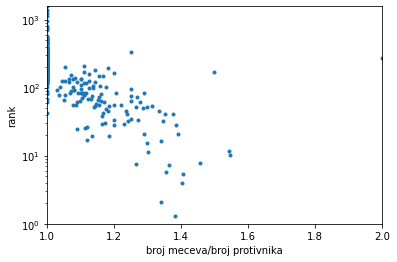

In [132]:
plot_num_of_opponents_per_rank(G,'linear','log')

# 12. Koji teniseri predstavljaju jezgro mreže?


In [133]:
from networkx.algorithms import core

core_graph = core.k_core(G)

print(nx.info(core_graph))

#da li je 78 od 219 jezgro?
core_nodes = [(node,name) for node,name in core_graph.nodes(data='player_name')]

#gustina znatno veca!
nx.density(core_graph)

Name: 
Type: Graph
Number of nodes: 78
Number of edges: 1077
Average degree:  27.6154


0.35864135864135865

# 13. Ko su teniseri koji povezuju različite grupe u okviru mreže?

In [134]:
betweenness_centralities = [(node, centrality) for node, centrality in nx.betweenness_centrality(G).items()]

max_betweenness_centralities = sorted(betweenness_centralities,key=lambda item: item[1], reverse=True)[:10]

high_betweenness_centralities_centrality_players = [(get_player_info(player[0]), player[1]) for player in max_betweenness_centralities]

print(f"Teniseri koji povezuju različite grupe u okviru mreže")
high_betweenness_centralities_centrality_players

Teniseri koji povezuju različite grupe u okviru mreže


[((104926, 'Fabio Fognini', 16.98076923076923, 'ITA'), 0.04675665554873781),
 ((104468, 'Gilles Simon', 51.23076923076923, 'FRA'), 0.040990635528978865),
 ((105173, 'Adrian Mannarino', 30.48076923076923, 'FRA'), 0.03811773413188154),
 ((105311, 'Joao Sousa', 56.34615384615385, 'POR'), 0.03626443281602215),
 ((126774, 'Stefanos Tsitsipas', 41.19230769230769, 'GRE'),
  0.02915493550630686),
 ((105683, 'Milos Raonic', 25.21153846153846, 'CAN'), 0.02889251581424229),
 ((105138, 'Roberto Bautista Agut', 19.73076923076923, 'ESP'),
  0.028524637534127227),
 ((111815, 'Cameron Norrie', 91.26923076923077, 'GBR'), 0.027878819888952997),
 ((105932, 'Nikoloz Basilashvili', 55.07692307692308, 'GEO'),
  0.0273524579581226),
 ((104291, 'Malek Jaziri', 71.09615384615384, 'TUN'), 0.026671294821369686)]

# 14. Kolika je gustina svake od modelovanih mreža?

In [135]:
nx.density(G)

0.05382154283682901

# 15. U kojoj meri su mreže povezane i centralizovane?

In [136]:
_,degrees = zip(*G.degree())

N=len(degrees)
max_degree = max(degrees)

#sum(max(x)-x)/(length(x)-1)
centralization = float((N*max_degree - sum(degrees)))/(N-1)**2

centralization

0.15014268727705113

In [137]:
def plot_players_per_centralities_frequency(G, xscale = "linear", yscale = "linear"):

    degree_centralities = [centrality for node, centrality in nx.degree_centrality(G).items()]
    centralities_counts = Counter(degree_centralities) #prebrojava, 1, 2, ..        
    print(centralities_counts)
    #lists = sorted(centralities_counts.items(),key=lambda item: item[1])
    x,frequency = zip(*centralities_counts.items())                                                      

    fig = plt.figure(1) 
    plt.xlabel('degree centrality')  
    plt.xscale(xscale)                                                                                                                
    plt.xlim(0, max(x))  

    plt.ylabel('frequency')                                                                                                          
    plt.yscale(yscale)                                                                                                                
    plt.ylim(1, max(frequency))                                                                                                             
                                                                                                                                                                                                    
    plt.scatter(x, frequency, marker='.')  
    plt.show()   

Counter({0.0034482758620689655: 63, 0.006896551724137931: 28, 0.013793103448275862: 14, 0.010344827586206896: 13, 0.017241379310344827: 11, 0.03103448275862069: 9, 0.027586206896551724: 7, 0.020689655172413793: 7, 0.06551724137931034: 7, 0.11724137931034483: 7, 0.04482758620689655: 6, 0.034482758620689655: 6, 0.14482758620689656: 6, 0.03793103448275862: 5, 0.08620689655172414: 5, 0.15517241379310345: 5, 0.1413793103448276: 4, 0.12068965517241378: 4, 0.13448275862068965: 4, 0.11379310344827587: 4, 0.09310344827586206: 4, 0.13103448275862067: 4, 0.12758620689655173: 4, 0.02413793103448276: 3, 0.041379310344827586: 3, 0.06896551724137931: 3, 0.1: 3, 0.12413793103448276: 3, 0.15172413793103448: 3, 0.04827586206896552: 3, 0.1586206896551724: 3, 0.16551724137931034: 3, 0.05517241379310345: 3, 0.13793103448275862: 3, 0.05862068965517241: 3, 0.05172413793103448: 3, 0.1103448275862069: 2, 0.0793103448275862: 2, 0.1793103448275862: 2, 0.16896551724137931: 2, 0.09655172413793103: 2, 0.14827586206

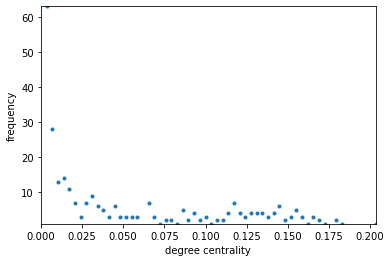

In [138]:
#ako ima nekoliko koji se izdvajaju sa velikom centralnoscu - centralizovan
#nas nije
plot_players_per_centralities_frequency(G)

In [139]:
# returns number of nodes to be removed 
# so that Graph becomes disconnected 
print(nx.node_connectivity(G)) 
  
# returns number of edges to be removed 
# so that Graph becomes disconnected 
print(nx.edge_connectivity(G))

#treba mnogo vremena!!!
#nx.average_node_connectivity(G)

1
1


# 16. Koje su prosečne distance, a koliki dijametar u okviru modelovanih mreža?

In [140]:
#ovoga vise nema kad smo izbacili Davis Cup!
# for g in [G.subgraph(c) for c in nx.connected_components(G)]: 
#     if len(g.nodes())<=4:
#         small_components=get_players_info(g.nodes())
#     if len(g.nodes())==19:
#         one_bigger_component=getPlayersInfo(g.nodes())
        
if nx.is_connected(G):
    print(f'Prosecna distanca: {(nx.average_shortest_path_length(G))}')
    print(f'Dijametar: {nx.diameter(G)}')
    
#za precnik mreze 12 nije mali svet
#za duzinu puta ~5 lici na fen. malog sveta

Prosecna distanca: 2.6714776632302404
Dijametar: 6


# 17. Kakva je distribucija čvorova po stepenu i da li prati neku zakonomernost? Kako je stepen čvora korelisan sa rejtingom tenisera?

Counter({1: 63, 2: 28, 4: 14, 3: 13, 5: 11, 9: 9, 8: 7, 6: 7, 19: 7, 34: 7, 13: 6, 10: 6, 42: 6, 11: 5, 25: 5, 45: 5, 41: 4, 35: 4, 39: 4, 33: 4, 27: 4, 38: 4, 37: 4, 7: 3, 12: 3, 20: 3, 29: 3, 36: 3, 44: 3, 14: 3, 46: 3, 48: 3, 16: 3, 40: 3, 17: 3, 15: 3, 32: 2, 23: 2, 52: 2, 49: 2, 28: 2, 43: 2, 22: 2, 31: 2, 26: 2, 50: 1, 30: 1, 21: 1, 59: 1, 53: 1, 47: 1, 24: 1})


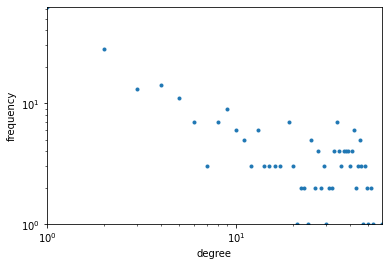

In [141]:
plot_deg_frequency(G, weighted=False)
#da ima veci broj cvorova?

In [142]:
def plot_deg_distribution(G, weighted=False, xscale = "log", yscale = "log"):

    if weighted:
        degrees = G.degree(weight="weight")
    else:
        degrees = G.degree()
    _, deg_list = zip(*degrees)    #unzip
    deg_counts = Counter(deg_list) #prebrojava, 1, 2, ..        
    print(deg_counts)
    degree, frequency = zip(*deg_counts.items())                                                      

    fig = plt.figure(1)
    plt.ylabel('degree')
    plt.ylabel('Broj cvorova')
    ax = fig.add_axes([0,0,1,1])
    ax.bar(degree,frequency)
    plt.show()

Counter({1: 63, 2: 28, 4: 14, 3: 13, 5: 11, 9: 9, 8: 7, 6: 7, 19: 7, 34: 7, 13: 6, 10: 6, 42: 6, 11: 5, 25: 5, 45: 5, 41: 4, 35: 4, 39: 4, 33: 4, 27: 4, 38: 4, 37: 4, 7: 3, 12: 3, 20: 3, 29: 3, 36: 3, 44: 3, 14: 3, 46: 3, 48: 3, 16: 3, 40: 3, 17: 3, 15: 3, 32: 2, 23: 2, 52: 2, 49: 2, 28: 2, 43: 2, 22: 2, 31: 2, 26: 2, 50: 1, 30: 1, 21: 1, 59: 1, 53: 1, 47: 1, 24: 1})


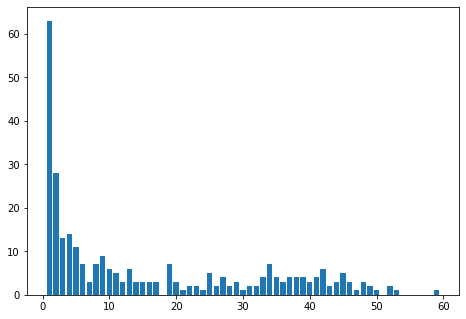

In [143]:
plot_deg_distribution(G)
#plot_deg_distribution(G, weighted=True)
#nije power-low

In [144]:
def plot_rank_degree(G, weight=True, xscale = "log", yscale = "log"):

    if (weight):
        rank_degree = [(rank,G.degree(weight='weight')[node]) for node,rank in G.nodes(data='rank')]
    else:
        rank_degree = [(rank,G.degree()[node]) for node,rank in G.nodes(data='rank')]
    rank, degree = zip(*rank_degree)                                                      

    plt.figure(1)   

    # prep axes   
    plt.xlabel('rank')                                                                                                             
    plt.xscale(xscale)                                                                                                                
    plt.xlim(1, max(rank))  

    plt.ylabel('degree')                                                                                                          
    plt.yscale(yscale)                                                                                                                
    plt.ylim(1, max(degree))                                                                                                             
                                                                                                                                                                                                    
    plt.scatter(rank, degree, marker='.')                                                                                                    
    plt.show()

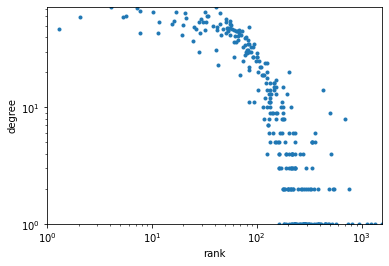

In [145]:
plot_rank_degree(G)

# 18. Da li u mreži postoje habovi i koji su? 

In [146]:
hubs,authorities = nx.hits(G)

high_hubs_players = [(get_player_info(node), h) for node,h in sorted(hubs.items(), key=lambda element: (element[1]),reverse=True)][:10]

high_hubs_players

#moze i eigen_vector

[((100644, 'Alexander Zverev', 4.038461538461538, 'GER'), 0.01688198134547859),
 ((104925, 'Novak Djokovic', 10.173076923076923, 'SRB'), 0.016479388053584846),
 ((104731, 'Kevin Anderson', 7.788461538461538, 'RSA'), 0.01638826927703048),
 ((126774, 'Stefanos Tsitsipas', 41.19230769230769, 'GRE'),
  0.016161277657248112),
 ((106233, 'Dominic Thiem', 7.230769230769231, 'AUT'), 0.01612370077502221),
 ((105453, 'Kei Nishikori', 20.615384615384617, 'JPN'), 0.01567226741694381),
 ((105223, 'Juan Martin Del Potro', 5.673076923076923, 'ARG'),
  0.014293717388618721),
 ((106421, 'Daniil Medvedev', 44.73076923076923, 'RUS'), 0.014135071772241109),
 ((111575, 'Karen Khachanov', 32.42307692307692, 'RUS'), 0.013937750086970352),
 ((103819, 'Roger Federer', 2.0576923076923075, 'SUI'), 0.013812574420222946)]

# 19. Da li mreža tenisera iskazuje osobine malog sveta?
A small world network is characterized by a small average shortest path length, and a large clustering coefficient.

Small-worldness is commonly measured with the coefficient sigma or omega.

Both coefficients compare the average clustering coefficient and shortest path length of a given graph against the same quantities for an equivalent random or lattice graph.

In [147]:
# #sigma>1
#sigma = nx.sigma(G)

# #~0
# omega = nx.omega(G)

# 20. Kakve su karakteristike ego mreža članova Velike trojke? U kojoj meri se te karakteristike razlikuju?

In [148]:
def get_average_ranks(G):
    ranks = [rank for node,rank in G.nodes(data='rank')]
    return sum(ranks)/len(ranks)

In [149]:
novak_id = get_player_by_name("Novak Djokovic")
rafa_id = get_player_by_name("Rafael Nadal")
federer_id = get_player_by_name("Roger Federer")

novak_ego_graph = nx.ego_graph(G,novak_id)
print(f"Novakova ego mreza : {nx.info(novak_ego_graph)}")
print(f"Prosecan tezinski stepen : {get_average_weighted_degree(novak_ego_graph)}")
print(f"Gustina mreze : {nx.density(novak_ego_graph)}")
print(f"Prosecan rank tenisera mreze : {get_average_ranks(novak_ego_graph)}")
novak_degree_centrality = [centrality for node, centrality in nx.degree_centrality(novak_ego_graph).items() if node==novak_id]
novak_eigenvector_centrality = [centrality for node, centrality in nx.eigenvector_centrality(novak_ego_graph).items() if node==novak_id]
print(f"Degree centrality : {novak_degree_centrality}")
print(f"Eigenvector centrality : {novak_eigenvector_centrality}")
print("\n")

rafa_ego_graph = nx.ego_graph(G,rafa_id)
print(f"Nadalova ego mreza : {nx.info(rafa_ego_graph)}")
print(f"Prosecan tezinski stepen : {get_average_weighted_degree(rafa_ego_graph)}")
print(f"Gustina mreze : {nx.density(rafa_ego_graph)}")
print(f"Prosecan rank tenisera mreze : {get_average_ranks(rafa_ego_graph)}")
rafa_degree_centrality = [centrality for node, centrality in nx.degree_centrality(rafa_ego_graph).items() if node==rafa_id]
rafa_eigenvector_centrality = [centrality for node, centrality in nx.eigenvector_centrality(rafa_ego_graph).items() if node==rafa_id]
print(f"Degree centrality : {rafa_degree_centrality}")
print(f"Eigenvector centrality : {rafa_eigenvector_centrality}")
print("\n")

federer_ego_graph = nx.ego_graph(G,federer_id)
print(f"Federerova ego mreza : {nx.info(federer_ego_graph)}")
print(f"Prosecan tezinski stepen : {get_average_weighted_degree(federer_ego_graph)}")
print(f"Gustina mreze : {nx.density(federer_ego_graph)}")
print(f"Prosecan rank tenisera mreze : {get_average_ranks(federer_ego_graph)}")
federer_degree_centrality = [centrality for node, centrality in nx.degree_centrality(federer_ego_graph).items() if node==federer_id]
federer_eigenvector_centrality = [centrality for node, centrality in nx.eigenvector_centrality(federer_ego_graph).items() if node==federer_id]
print(f"Degree centrality : {federer_degree_centrality}")
print(f"Eigenvector centrality : {federer_eigenvector_centrality}")

Novakova ego mreza : Name: 
Type: Graph
Number of nodes: 43
Number of edges: 320
Average degree:  14.8837
Prosecan tezinski stepen : 20.6046511627907
Gustina mreze : 0.35437430786268
Prosecan rank tenisera mreze : 49.48345259391771
Degree centrality : [1.0]
Eigenvector centrality : [0.33240066330643975]


Nadalova ego mreza : Name: 
Type: Graph
Number of nodes: 35
Number of edges: 214
Average degree:  12.2286
Prosecan tezinski stepen : 16.34285714285714
Gustina mreze : 0.3596638655462185
Prosecan rank tenisera mreze : 54.753846153846155
Degree centrality : [1.0]
Eigenvector centrality : [0.3499083477074309]


Federerova ego mreza : Name: 
Type: Graph
Number of nodes: 45
Number of edges: 349
Average degree:  15.5111
Prosecan tezinski stepen : 20.31111111111111
Gustina mreze : 0.3525252525252525
Prosecan rank tenisera mreze : 49.62222222222222
Degree centrality : [1.0]
Eigenvector centrality : [0.3320769184035492]


In [150]:
novak_nodes = set(novak_ego_graph.nodes())
rafa_nodes = set(rafa_ego_graph.nodes())
federer_nodes = set(federer_ego_graph.nodes())

novak_rafa_node = novak_nodes.intersection(rafa_nodes)
novak_federer_node = novak_nodes.intersection(federer_nodes)
rafa_federer_node = rafa_nodes.intersection(federer_nodes)

print(f"Novak i Rafa: {len(novak_rafa_node)}")
print(f" {get_players_info(novak_rafa_node)}")
print("\n")
print(f"Novak i Federer: {len(novak_federer_node)}")
print(f" {get_players_info(novak_federer_node)}")
print("\n")
print(f"Federer i Rafa: {len(rafa_federer_node)}")
print(f" {get_players_info(rafa_federer_node)}")

Novak i Rafa: 16
 [(104925, 'Novak Djokovic', 10.173076923076923, 'SRB'), (100644, 'Alexander Zverev', 4.038461538461538, 'GER'), (105223, 'Juan Martin Del Potro', 5.673076923076923, 'ARG'), (104745, 'Rafael Nadal', 1.3076923076923077, 'ESP'), (105227, 'Marin Cilic', 5.326923076923077, 'CRO'), (105932, 'Nikoloz Basilashvili', 55.07692307692308, 'GEO'), (105453, 'Kei Nishikori', 20.615384615384617, 'JPN'), (106000, 'Damir Dzumhur', 33.11538461538461, 'BIH'), (105777, 'Grigor Dimitrov', 7.653846153846154, 'BUL'), (104755, 'Richard Gasquet', 29.596153846153847, 'FRA'), (105332, 'Benoit Paire', 50.53846153846154, 'FRA'), (126774, 'Stefanos Tsitsipas', 41.19230769230769, 'GRE'), (111575, 'Karen Khachanov', 32.42307692307692, 'RUS'), (104792, 'Gael Monfils', 38.07692307692308, 'FRA'), (106233, 'Dominic Thiem', 7.230769230769231, 'AUT'), (105373, 'Martin Klizan', 99.90384615384616, 'SVK')]


Novak i Federer: 20
 [(105223, 'Juan Martin Del Potro', 5.673076923076923, 'ARG'), (105227, 'Marin Cil

# 21. Kakva je pozicija ego čvora u svakoj od ego mreža? Kako su oni strukturno ugrađeni u mrežu?

In [151]:
novak_edges = [edge for edge in novak_ego_graph.edges(nbunch=novak_id)]
edges = novak_ego_graph.edges()

print(f"Procenat Novakovih veza = {len(novak_edges)*100/len(edges)}")

rafa_edges = [edge for edge in rafa_ego_graph.edges(nbunch=rafa_id)]
edges = rafa_ego_graph.edges()

print(f"Procenat Nadalovih veza = {len(rafa_edges)*100/len(edges)}")

federer_edges = [edge for edge in federer_ego_graph.edges(nbunch=federer_id)]
edges = novak_ego_graph.edges()

print(f"Procenat Federerovih veza = {len(federer_edges)*100/len(edges)}")

Procenat Novakovih veza = 13.125
Procenat Nadalovih veza = 15.88785046728972
Procenat Federerovih veza = 13.75


# 22. Kako su posmatrane ego mreže ugrađene u mrežu tenisera?

In [152]:
novak_ego_edges = [edge for edge in novak_ego_graph.edges()]
edges = [edge for edge in G.edges()]

print(f"Procenat Novakovih veza u ego i obicnoj mrezi = {len(novak_ego_edges)*100/len(edges)}")
print(f"Procenat Novakovih suparnika u obicnoj mrezi = {len(novak_nodes)*100/len(G.nodes())}")

Procenat Novakovih veza u ego i obicnoj mrezi = 14.090708938793483
Procenat Novakovih suparnika u obicnoj mrezi = 14.776632302405499


In [153]:
rafa_ego_edges = [edge for edge in rafa_ego_graph.edges()]
edges = [edge for edge in G.edges()]

print(f"Procenat Nadalovih veza u ego i obicnoj mrezi = {len(rafa_ego_edges)*100/len(edges)}")
print(f"Procenat Nadalovih suparnika u obicnoj mrezi = {len(rafa_nodes)*100/len(G.nodes())}")

Procenat Nadalovih veza u ego i obicnoj mrezi = 9.423161602818142
Procenat Nadalovih suparnika u obicnoj mrezi = 12.027491408934708


In [154]:
federer_ego_edges = [edge for edge in federer_ego_graph.edges()]
edges = [edge for edge in G.edges()]

print(f"Procenat Federerovih veza u ego i obicnoj mrezi = {len(federer_ego_edges)*100/len(edges)}")
print(f"Procenat Federerovih suparnika u obicnoj mrezi = {len(federer_nodes)*100/len(G.nodes())}")

Procenat Federerovih veza u ego i obicnoj mrezi = 15.367679436371642
Procenat Federerovih suparnika u obicnoj mrezi = 15.463917525773196


# 23. Analizirati mrežu dobijenu unifikacijom ego mreža članova Velike trojke.
## Koji procenat čvorova mreže svih tenisera učestvuje u njoj?
## Sprovesti klasterisanje ovako dobijene mreže na tri klastera i na osnovu dobijenih rezultata dati interpretaciju kriterijuma pripadnosti klasterima.


In [155]:
all_edges = set(novak_ego_edges).union(set(rafa_ego_edges)).union(set(federer_ego_edges))

u = G.edge_subgraph(all_edges)
print(f"Unificirana mreza : {nx.info(u)}")
print(f"Prosecan tezinski stepen : {get_average_weighted_degree(u)}")
print(f"Gustina mreze : {nx.density(u)}")
print(f"Prosecan rank tenisera mreze : {get_average_ranks(u)}")

Unificirana mreza : Name: 
Type: Graph
Number of nodes: 81
Number of edges: 673
Average degree:  16.6173
Prosecan tezinski stepen : 21.555555555555557
Gustina mreze : 0.20771604938271604
Prosecan rank tenisera mreze : 62.02302943969611


In [156]:
print(f"Procenat cvorova u unificirano mrezi = {len(u.nodes())*100/len(G.nodes())}")

Procenat cvorova u unificirano mrezi = 27.835051546391753


In [157]:
data = u.nodes()
edge_mat = nx.to_numpy_matrix(u,nodelist=data,weight='weight')

kmeans = cluster.KMeans(n_clusters=3, n_init=200)

kmeans = kmeans.fit(edge_mat)

#initialize dict
clusters = {}
for index in range(0,3): 
    nodes = []    
    clusters[index] = nodes
    
for cluster_info in zip(data,kmeans.labels_):
    clusters[cluster_info[1]].append(cluster_info[0])
#clusters

In [158]:
N = len(u.nodes())

num_of_ego_graphs = {}
for node in u.nodes():
    n = 1 if node in novak_ego_graph else 0
    r = 1 if node in rafa_ego_graph else 0
    f = 1 if node in federer_ego_graph else 0
    #num_of_ego_graphs[node] = pow(n+r+f,10)
    num_of_ego_graphs[node] = n+r+f
    #num_of_ego_graphs[node] = pow(n+r+f,5)

#edge_matrix =  np.array([[0 for i in range(N)]] * N )
edge_matrix =  np.array([[0 for i in range(2)]] * N )
node_index = 0
for node in u.nodes():
    for neighbor in u.neighbors(node):
        neighbor_index = list(u.nodes()).index(neighbor)
        edge_matrix[node_index,1] = num_of_ego_graphs[node]
        #edge_matrix[node_index,neighbor_index] = abs(num_of_ego_graphs[node] - num_of_ego_graphs[neighbor])
        #edge_matrix[node_index,neighbor_index] = 3-abs(num_of_ego_graphs[node] - num_of_ego_graphs[neighbor])
        #edge_matrix[node_index,node_index] = num_of_ego_graphs[node]
    node_index+=1
        
edge_matrix

array([[0, 1],
       [0, 3],
       [0, 3],
       [0, 2],
       [0, 1],
       [0, 1],
       [0, 2],
       [0, 1],
       [0, 3],
       [0, 1],
       [0, 2],
       [0, 3],
       [0, 3],
       [0, 1],
       [0, 2],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 2],
       [0, 2],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 2],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 2],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 2],
       [0, 1],
       [0, 3],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 2],
       [0, 2],
       [0, 2],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 2],
       [0, 1],
       [0, 2],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 2],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 2],
       [0, 2],
       [0,

In [159]:
kmeans = cluster.KMeans(n_clusters=3, n_init=200)

kmeans = kmeans.fit(edge_matrix)

#initialize dict
big_three_clusters = {}
for index in range(0,3): 
    nodes = []    
    big_three_clusters[index] = nodes
    
for cluster_info in zip(data,kmeans.labels_):
    big_three_clusters[cluster_info[1]].append(cluster_info[0])
big_three_clusters

{0: [105223, 105227, 100644, 105777, 104755, 105332, 104925, 105453, 106233],
 1: [104198,
  104468,
  105238,
  103970,
  104999,
  105526,
  133430,
  106043,
  106045,
  104259,
  104269,
  105806,
  106065,
  105041,
  144719,
  104534,
  105815,
  200282,
  105051,
  105311,
  104545,
  104547,
  105062,
  105577,
  104297,
  105074,
  105077,
  104312,
  106121,
  106378,
  104607,
  105376,
  106401,
  106148,
  105385,
  109739,
  104620,
  105643,
  106415,
  106421,
  103607,
  106423,
  105657,
  104898,
  105166,
  105936,
  106210,
  105449],
 2: [106000,
  104731,
  104745,
  126774,
  105550,
  104527,
  104792,
  111202,
  105583,
  103819,
  105357,
  105373,
  105379,
  104871,
  105138,
  105916,
  106432,
  105676,
  105932,
  105683,
  105173,
  104919,
  111575,
  104926]}

In [160]:
def get_players_cluster(id):
    for cluster_index in range(0,3):
        if id in clusters[cluster_index]:
            return cluster_index

In [161]:
get_players_cluster(novak_id)

1

In [162]:
get_players_cluster(rafa_id)

1

In [163]:
get_players_cluster(federer_id)

0

# 24. Kakva je distribucija broja tenisera u odnosu na broj mečeva koji su odigrali?

Counter({1: 63, 2: 26, 4: 14, 3: 14, 5: 11, 6: 8, 8: 7, 9: 7, 11: 6, 10: 6, 14: 5, 13: 5, 54: 5, 46: 5, 43: 5, 27: 5, 47: 4, 45: 4, 42: 4, 19: 4, 16: 4, 30: 4, 35: 3, 22: 3, 33: 3, 49: 3, 52: 3, 48: 3, 31: 3, 25: 3, 15: 3, 20: 3, 57: 2, 24: 2, 29: 2, 41: 2, 7: 2, 73: 2, 36: 2, 59: 2, 55: 2, 66: 2, 12: 2, 38: 2, 51: 2, 61: 2, 64: 2, 34: 1, 23: 1, 67: 1, 60: 1, 50: 1, 21: 1, 65: 1, 40: 1, 18: 1, 28: 1, 71: 1, 39: 1, 17: 1, 58: 1, 37: 1})


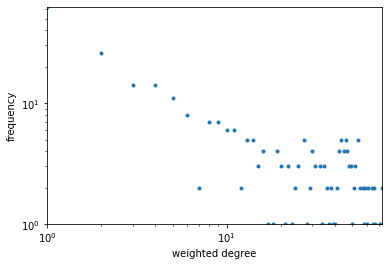

In [164]:
plot_deg_frequency(G, weighted = True)

# 25. Kakva je distribucija broja turnira u odnosu na podlogu i godinu održavanja?

In [165]:
def plot_tourney_per_surface_frequency(G, xscale = "linear", yscale = "linear"):

    surfaces = [surface for node,surface in G.nodes(data='surface')]
    surfaces_counts = Counter(surfaces) #prebrojava, 1, 2, ..        
    surfaces_counts = (sorted(surfaces_counts.items(), key=lambda element: (element[1]),reverse=True))
    print(surfaces_counts)
    surface, num_of_tourneys = zip(*surfaces_counts)                                                      

    fig = plt.figure(1)   
    plt.ylabel('Број турнира')
    ax = fig.add_axes([0,0,1,1])
    ax.bar(surface,num_of_tourneys)
    plt.show()

[('Hard', 38), ('Clay', 22), ('Grass', 8)]


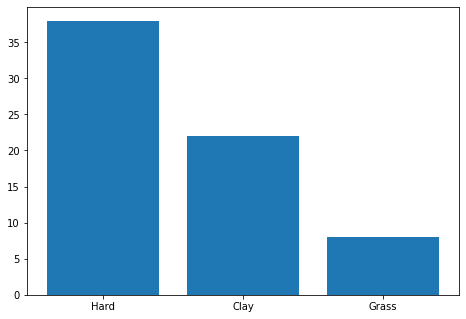

In [166]:
tourney_sub_graph = tourney_graph.subgraph(tourney_nodes)

plot_tourney_per_surface_frequency(tourney_sub_graph)

# 26. Kakva je distribucija broja mečeva u odnosu na podlogu i godinu održavanja?

In [167]:
def plot_matches_per_surface_frequency(G, xscale = "linear", yscale = "linear"):

    data = [(surface,int((tourney_graph.degree(node,weight="weight"))/2)) for node,surface in tourney_graph.nodes(data='surface') if  node in tourney_names]

    dictionary = dict()
    for (surface, val) in data: 
        dictionary[surface] = dictionary.get(surface, 0) + val  # return the value for that key or return default 0 (and create key)
    surface=list(dictionary.keys())
    num_of_matches=list(dictionary.values())
    print(dictionary)

    fig = plt.figure(1)   
  
    ax = fig.add_axes([0,0,1,1])
    ax.bar(surface,num_of_matches)
    plt.show()

{'Hard': 1519, 'Clay': 810, 'Grass': 324}


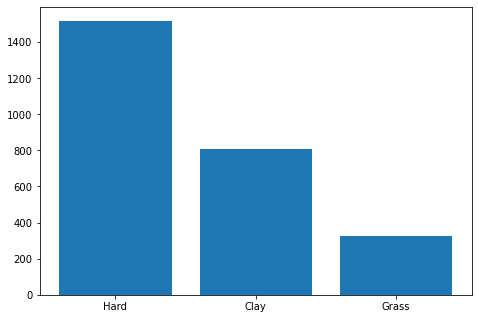

In [168]:
plot_matches_per_surface_frequency(tourney_graph)

#u proseku na svakom turniru po 40 meceva

# Cuvanje grafa

In [169]:
nx.write_gexf(G,output_gz_path)

# Vizuelizacija

In [170]:
def get_gephi_rank_group(rank):
    if rank<10:
        return 'group10'
    if rank<20:
        return 'group20'
    if rank<50:
        return 'group50'
    if rank<100:
        return 'group100'
    if rank<250:
        return 'group250'
    if rank<500:
        return 'group500'
    if rank<2000:
        return 'group2000'
    return 'group2000'

def add_gephi_rank_group_attribute(G):
    for player in G.nodes:
        G.nodes[player]['rank_group']=get_gephi_rank_group(G.nodes[player]['rank'])
        
def reverse_rank(G):
    for player in G.nodes:
        rank = G.nodes[player]['rank']
        G.nodes[player]['rank']=-rank if not np.isnan(rank) else -float(2000)

def set_ego_node_attribute(G,ego_nodes,ego_type):  
    for player in G.nodes:
        G.nodes[player]['node_type']=ego_type if player in ego_nodes else 'not_ego_node'
        
def set_ego_edge_attribute(G,ego_edges,ego_type):         
    for (source,target) in G.edges:
        G.edges[source,target]['edge_type']=ego_type if (((source,target) in ego_edges) | ((target,source) in ego_edges)) else 'not_ego_edge'          
        
def set_ego_attribute(G,ego_nodes,ego_edges,ego_type):  
    set_ego_node_attribute(G,ego_nodes,ego_type)
    set_ego_edge_attribute(G,ego_edges,ego_type)

def set_community_attribute(G):
    for key, values in communities_info.items():
        for value in values:
            G.nodes[value[0]]['community'] = key

def set_cluster_attribute(G):
    for key, values in clusters.items():
        for value in values:
            G.nodes[value]['cluster'] = key
    # hocu da mi se u gephi-ju prikazuje label samo za ovu trojicu pa cu to ovako da uradim
    for player in G.nodes():
        G.nodes[player]['help_label'] = G.nodes[player]['player_name'] if G.nodes[player]['player_name'] in ['Novak Djokovic', 'Rafael Nadal', 'Roger Federer'] else ''
        
def set_big_three_clusters_attribute(G):
    for key, values in big_three_clusters.items():
        for value in values:
            G.nodes[value]['big_three_clusters'] = key
    # hocu da mi se u gephi-ju prikazuje label samo za ovu trojicu pa cu to ovako da uradim
    for player in G.nodes():
        G.nodes[player]['help_label'] = G.nodes[player]['player_name'] if G.nodes[player]['player_name'] in ['Novak Djokovic', 'Rafael Nadal', 'Roger Federer'] else ''
        

In [171]:
def relable(G):
    values = [name for node,name in G.nodes(data='player_name')]
    mapping  = dict(zip(G, values))

    return  nx.relabel_nodes(G, mapping)   

def arrange_graph(G):
    H = copy.deepcopy(G)

    add_gephi_rank_group_attribute(H)
    
    reverse_rank(H)    
    return relable(H)

def arrange_ego_in_graph(G,nodes,edges,node_type):
    H = copy.deepcopy(G)
    
    set_ego_attribute(H,nodes,edges,node_type)
    reverse_rank(H) 
    return relable(H)

def arrange_ego_graph(G,edges,node_type):
    H = copy.deepcopy(G)
    
    set_ego_edge_attribute(H,edges,node_type)
    reverse_rank(H) 
    return relable(H)

def arrange_communities(G):
    H = copy.deepcopy(G)
    
    set_community_attribute(H)
    add_gephi_rank_group_attribute(H)
    reverse_rank(H)
    return relable(H)

def arrange_clusters(G):
    H = copy.deepcopy(G)
    
    set_cluster_attribute(H)
    add_gephi_rank_group_attribute(H)
    reverse_rank(H)
    return relable(H)

def arrange_big_three_clusters(G):
    H = copy.deepcopy(G)
    
    set_big_three_clusters_attribute(H)
    add_gephi_rank_group_attribute(H)
    reverse_rank(H)
    return relable(H)

In [173]:
nx.write_gml(arrange_graph(G), output_gml_path)

nx.write_gml(arrange_ego_in_graph(G,novak_nodes,novak_ego_edges,'novak'), "novak_ego_in_2018.gml")
nx.write_gml(arrange_ego_in_graph(G,rafa_nodes,rafa_ego_edges,'rafa'), "rafa_ego_in_2018.gml")
nx.write_gml(arrange_ego_in_graph(G,federer_nodes,federer_ego_edges,'federer'), "federer_ego_in_2018.gml")

nx.write_gml(arrange_ego_graph(novak_ego_graph,novak_edges,'novak'), "novak_ego_graph_2018.gml")
nx.write_gml(arrange_ego_graph(rafa_ego_graph,rafa_edges,'rafa'), "rafa_ego_graph_2018.gml")
nx.write_gml(arrange_ego_graph(federer_ego_graph,federer_edges,'federer'), "federer_ego_graph_2018.gml")

nx.write_gml(arrange_communities(G), "communities_2018.gml")
nx.write_gml(arrange_clusters(u), "clusters_unified_graph_2018.gml")

#asyn_fluid_clusters
#nx.write_gml(arrange_asyn_fluid_clusters(u), "asyn_fluid_clusters_unified_graph_2018.gml")

nx.write_gml(arrange_big_three_clusters(u), "big_three_clusters_unified_graph_2018.gml")